In [229]:
import pandas as pd
import numpy as np
import time


from sklearn import preprocessing as prep
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegressionCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn import preprocessing
from sklearn.impute import KNNImputer

import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mno

import pycountry as pc

import statsmodels.api
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as ss
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [230]:
df = pd.read_csv('hotel_bookings.csv')

# Hotel Booking Prediction

# 1. Abstract

* Our goal is to predict those cancellation booking and our target variable is 'is_canceled '. 

* After observing and testing the data, we find that those missingness are not missing at random, so we apply knn imputation to fill these missing data.

* In terms of predictors, we use the ANOVA test to select the categorical variables and choose numeric variables as our predictors through their correalation coefficient with target variable. 

* Then, we apply SMOTH to deal with the issue of unbalance in our data. 

* The final result is the Random Froest has the best AUC in test set, which is 0.98, and the Decision Tree perfrom the best among others if we take account to the time efficiency, which can achieve 0.93 in AUC and only cost 3.5 minutes.

# 2. Introduction

This data contains 119,390 hotel records where each record represents a single booking for a city hotel and a resort hotel in Portugal for the years 2015–2017, and there are 34 variables in this data. 

* Our aim is to help this company accurately predict and respond to booking cancellations through the classifiers we train.

# 3. Exploratory Data Analysis

## 3.1 Missing Values

### 3.1.1 Detecting missing values

We focus on the missing values in our data before any analyzing, and we find that there are four columns containing missing values. This fact can be found in the table in cell 3 and graph in cell 5.

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [232]:
print("There are %s missing values in 'children'" % ('{:.3%}'.format((df['children'].isna().sum())/119389)))
print("There are %s missing values in 'country'" % ('{:.3%}'.format((df['country'].isna().sum())/119389)))
print("There are %s missing values in 'agent'" % ('{:.3%}'.format((df['agent'].isna().sum())/119389)))
print("There are %s missing values in 'company'" % ('{:.3%}'.format((df['company'].isna().sum())/119389)))
df['agent'] = df['agent'].astype('object')

There are 0.003% missing values in 'children'
There are 0.409% missing values in 'country'
There are 13.686% missing values in 'agent'
There are 94.308% missing values in 'company'


<AxesSubplot:>

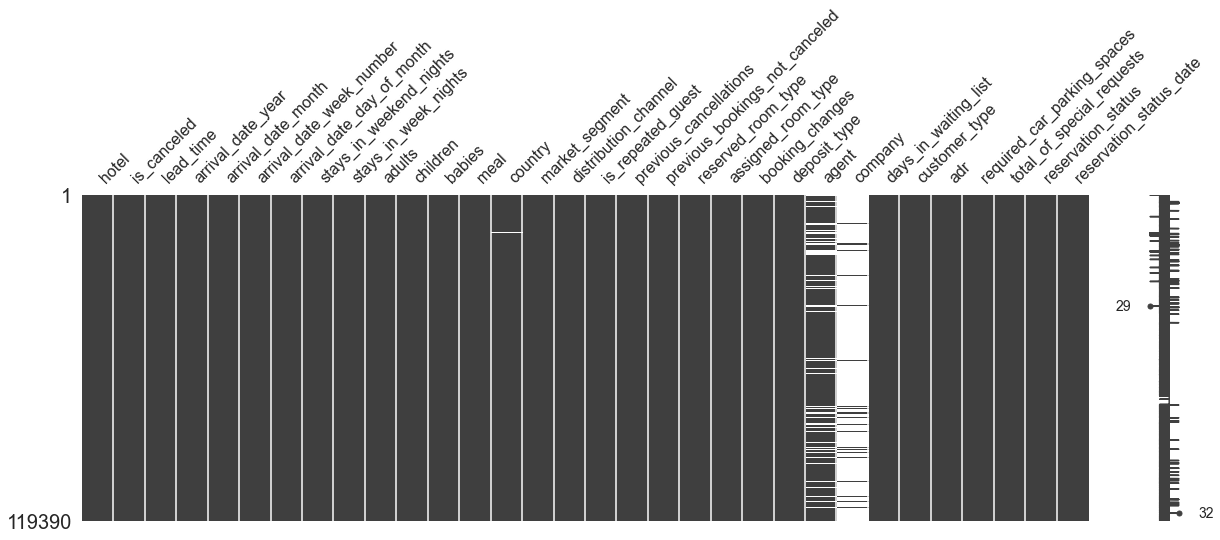

In [233]:
mno.matrix(df, figsize = (20, 6))

Then, we want to further understand the relationships among these columns with missing values. One interesting found is that there is a moderate negative relationship between 'company' and 'agent', this can be observed in the heatmap in cell 6.

Although dropping the column with missing value is not the best way to hanlde the issue of missing value, we still decide to drop 'company' since there are too many missingness in this variable, and if we apply the imputation methods, like regression impution or knn impution, before trainning our classifiers, sometimes it could lead overfitting in our model.

<AxesSubplot:>

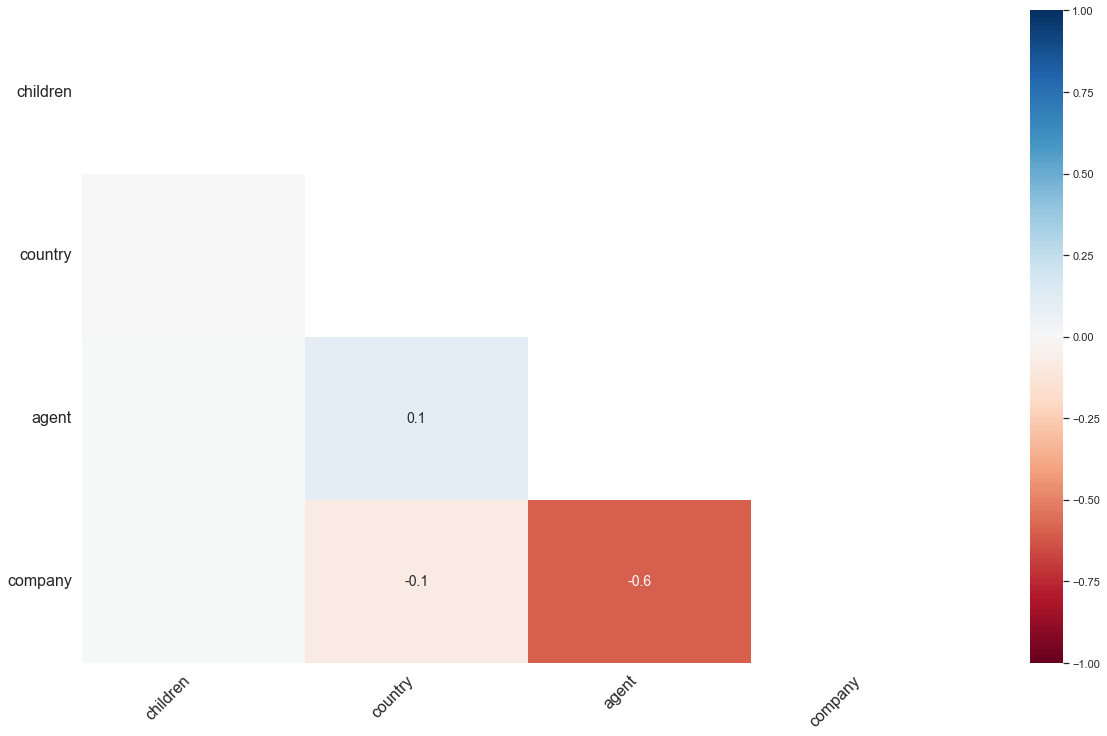

In [234]:
mno.heatmap(df)

In [235]:
df.drop(['company'],axis=1,inplace=True)

In [236]:
# Initialize the Dice columns
df["country_missing"] = df["country"]
df["children_missing"] = df["children"]
df["agent_missing"] = df["agent"]
# The column is false
df["country_missing"] = False
df["children_missing"] = False
df["agent_missing"] = False
# Replace where children_missing with True where children is missing
df.loc[df[df['country'].isnull()].index, "country_missing"] = True 
df.loc[df[df['children'].isnull()].index, "children_missing"] = True 
df.loc[df[df['agent'].isnull()].index, "agent_missing"] = True 

### 3.1.2 Detecting the MCAR pattern

MCAR stands for Missing Completely At Random. Data missing completely at random means that the probability of missingness in one independent variable does not depend on the other observed independent variables. In other words, the probability of missingness in an indepdent variable depends only on some external factors.

We use chi-test to test whether these missing values is MCAR at the condidence level 95%. The null hypothesis is...

* H<sub>0</sub> : there is no association between the missingness in the missing column and the other columns. 



In [237]:
# Deifen the MCAR test formlua
def MCAR(x):
        List=[]
        for y in df[df.columns.difference([x,'country','agent','children'])].columns:
            T = df.groupby(y)[x].apply(lambda x: (x==True).sum())
            F = df.groupby(y)[x].apply(lambda x: (x==False).sum())
            templist = []
            for i in range(len(T)):
                templist.append([T.iloc[i],F.iloc[i]])
            chi2, p, dof, ex = chi2_contingency(np.array(templist))
            List.append([y,p.round(10)])
        return List

In [238]:
country_missing = MCAR('country_missing')
agent_missing = MCAR('agent_missing')
children_missing = MCAR('children_missing')

country_missing = pd.DataFrame(country_missing, columns =['Column2', 'P-value'])
country_missing.insert(loc=0, column='Column1', value='country_missing')

agent_missing = pd.DataFrame(agent_missing, columns =['Column2', 'P-value'])
agent_missing.insert(loc=0, column='Column1', value='agent_missing')

children_missing = pd.DataFrame(children_missing, columns =['Column2', 'P-value'])
children_missing.insert(loc=0, column='Column1', value='children_missing')

pvaluetable = pd.concat([country_missing,agent_missing,children_missing],join='inner')

pvaluetable['Ho'] = np.where((pvaluetable['P-value'] >= 0.05),'reject','not_reject')

pvaluetableNr = pvaluetable[pvaluetable['Ho']=='not_reject']

display(pvaluetableNr)
df.drop(columns = ['agent_missing','children_missing','country_missing'],inplace=True)

,Column1,Column2,P-value,Ho
1,country_missing,adults,0.000000,not_reject
2,country_missing,agent_missing,0.000000,not_reject
3,country_missing,arrival_date_day_of_month,0.009546,not_reject
4,country_missing,arrival_date_month,0.000000,not_reject
5,country_missing,arrival_date_week_number,0.000000,not_reject
...,...,...,...,...
16,children_missing,is_canceled,0.036638,not_reject
19,children_missing,market_segment,0.000000,not_reject
24,children_missing,reservation_status,0.028697,not_reject
25,children_missing,reservation_status_date,0.000000,not_reject


Most hypothesis tests show the result do not reject the null hypothesis, which means those columns associate with these missing data, this can be found in cell 10, so we are going to apply Knn imputation on the columns with missing data. After imputation, the data become complete. This can be found in cell 12.

In [239]:
lehotel = preprocessing.LabelEncoder()
lehotel.fit([x for x in df.hotel])
df.hotel = lehotel.transform(df['hotel'][df['hotel'].notnull()])

lemonth = preprocessing.LabelEncoder()
lemonth.fit([x for x in df.arrival_date_month])
df.arrival_date_month=lemonth.transform(df['arrival_date_month'][df['arrival_date_month'].notnull()])

lemeal= preprocessing.LabelEncoder()
lemeal.fit([x for x in df.meal])
df.meal=lemeal.transform(df['meal'][df['meal'].notnull()])


le = preprocessing.LabelEncoder()
le.fit([x for x in df.country])
df.country=pd.Series(le.transform(df['country'][df['country'].notnull()]),index=df.country[df.country.notnull()].index)

lemarket = preprocessing.LabelEncoder()
lemarket.fit([x for x in df.market_segment])
df.market_segment=lemarket.transform(df['market_segment'][df['market_segment'].notnull()])

ledist = preprocessing.LabelEncoder()
ledist.fit([x for x in df.distribution_channel])
df.distribution_channel=ledist.transform(df['distribution_channel'][df['distribution_channel'].notnull()])

lere = preprocessing.LabelEncoder()
lere.fit([x for x in df.reserved_room_type])
df.reserved_room_type=lere.transform(df['reserved_room_type'][df['reserved_room_type'].notnull()])

leas = preprocessing.LabelEncoder()
leas.fit([x for x in df.assigned_room_type])
df.assigned_room_type=leas.transform(df['assigned_room_type'][df['assigned_room_type'].notnull()])

lead = preprocessing.LabelEncoder()
lead.fit([x for x in df.deposit_type])
df.deposit_type=lead.transform(df['deposit_type'][df['deposit_type'].notnull()])

lec = preprocessing.LabelEncoder()
lec.fit([x for x in df.customer_type])
df.customer_type=lec.transform(df['customer_type'][df['customer_type'].notnull()])

lestatus = preprocessing.LabelEncoder()
lestatus.fit([x for x in df.reservation_status])
df.reservation_status=lestatus.transform(df['reservation_status'][df['reservation_status'].notnull()])

lestatusd = preprocessing.LabelEncoder()
lestatusd.fit([x for x in df.reservation_status_date])
df.reservation_status_date=lestatusd.transform(df['reservation_status_date'][df['reservation_status_date'].notnull()])

imputer = KNNImputer(n_neighbors=3)
new = imputer.fit_transform(df)

dfwithoutNA = pd.DataFrame(columns = df.columns, data=new)

dfwithoutNA.hotel = dfwithoutNA.hotel.astype('int')
dfwithoutNA.hotel = lehotel.inverse_transform(dfwithoutNA['hotel'])

dfwithoutNA.arrival_date_month = dfwithoutNA.arrival_date_month.astype('int')
dfwithoutNA.arrival_date_month = lemonth.inverse_transform(dfwithoutNA['arrival_date_month'])

dfwithoutNA.meal = dfwithoutNA.meal.astype('int')
dfwithoutNA.meal = lemeal.inverse_transform(dfwithoutNA['meal'])

dfwithoutNA.country = dfwithoutNA.country.astype('int')
dfwithoutNA.country = le.inverse_transform(dfwithoutNA['country'])

dfwithoutNA.market_segment = dfwithoutNA.market_segment.astype('int')
dfwithoutNA.market_segment = lemarket.inverse_transform(dfwithoutNA['market_segment'])

dfwithoutNA.distribution_channel = dfwithoutNA.distribution_channel.astype('int')
dfwithoutNA.distribution_channel = ledist.inverse_transform(dfwithoutNA['distribution_channel'])

dfwithoutNA.reserved_room_type = dfwithoutNA.reserved_room_type.astype('int')
dfwithoutNA.reserved_room_type = lere.inverse_transform(dfwithoutNA['reserved_room_type'])

dfwithoutNA.assigned_room_type = dfwithoutNA.assigned_room_type.astype('int')
dfwithoutNA.assigned_room_type = leas.inverse_transform(dfwithoutNA['assigned_room_type'])

dfwithoutNA.deposit_type = dfwithoutNA.deposit_type.astype('int')
dfwithoutNA.deposit_type = lead.inverse_transform(dfwithoutNA['deposit_type'])

dfwithoutNA.customer_type = dfwithoutNA.customer_type.astype('int')
dfwithoutNA.customer_type = lec.inverse_transform(dfwithoutNA['customer_type'])

dfwithoutNA.reservation_status = dfwithoutNA.reservation_status.astype('int')
dfwithoutNA.reservation_status = lestatus.inverse_transform(dfwithoutNA['reservation_status'])

dfwithoutNA.reservation_status_date = dfwithoutNA.reservation_status_date.astype('int')
dfwithoutNA.reservation_status_date = lestatusd.inverse_transform(dfwithoutNA['reservation_status_date'])

<AxesSubplot:>

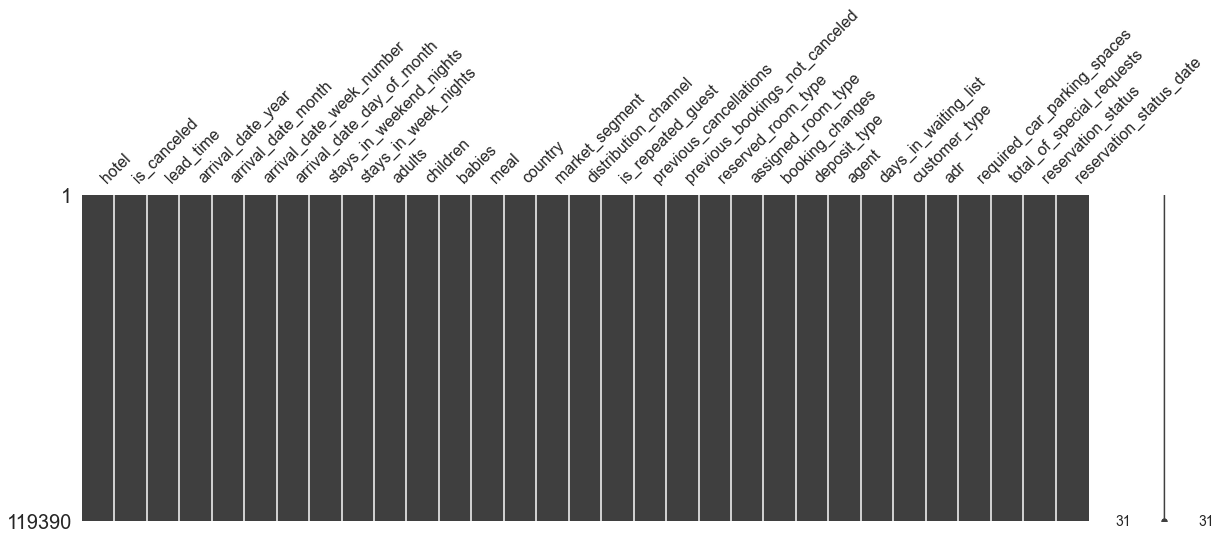

In [240]:
mno.matrix(dfwithoutNA, figsize = (20, 6))

## 3.2 Numeric Variables

In [242]:
df = dfwithoutNA
# Transform the columns not belong to the numeric variables.
df['agent'] = df['agent'].round().astype('object')
df['is_canceled'] = df['is_canceled'].astype('object') 
df['is_repeated_guest']=df['is_repeated_guest'].astype('object')
df['reservation_status_date'] = pd.to_datetime(df.reservation_status_date)
df['reservation_status_date'] = df['reservation_status_date'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
dfnumeric = df.select_dtypes(include='number')
display(dfnumeric.describe().T)

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119390.0,0.103895,0.398564,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0


We convert some numeric variables in this data to the categotical variables because the values in these variables  are meanless, there is no intrinsic ordering to these values, for example, there is no order in 'agent', which merely represents each agent's ID.

By observing the table in cell 13, we know that the variance in most numerical variables is larger than their mean, which means there is a big variety in those variables,so this data is necessary to be normalized before applying machine learning method.

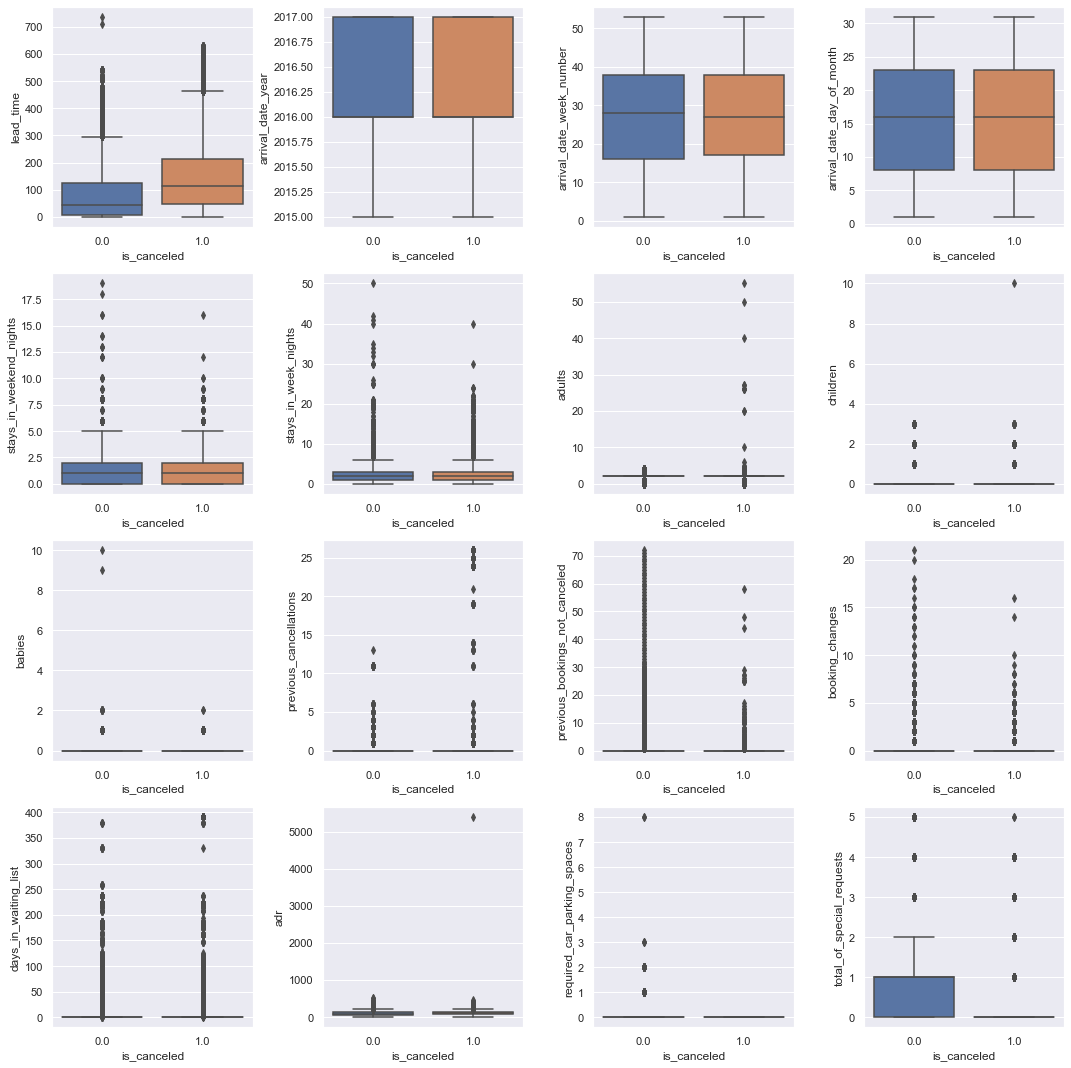

In [243]:
names = dfnumeric.columns
ncols = len(names)
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(15,15))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= df['is_canceled'], data=dfnumeric, orient='v', ax=ax)
    
plt.tight_layout()

As the plots above in cell 14 shown, some variables have many outliers. We can not only normalize them but also transform some of them to categorical variables. Those variables with zero IQR can be made to a binary variable because those outliers are meaningless and can be problematic when ruuning machine learning methods, so I transform each of them to a new categorical variable. There is an outlier in adr. In this special case, which only contains only one outliers, we decided to drop this point to prevent our model influenced by this outlier.

As the heatmap shown in cell 16, 'lead_time' and 'total_of_special_requests' have a high correlation with our target variable 'is_canceled', which is greater than 0.1, so these two vairables will be selected into our predictors.

In [244]:
# Transform to categorical variables
# adr
df = df[df['adr']<5400]
# other
df['adults'] = np.where((df['adults'] >= 1),'1','0')
df['children'] = np.where((df['children'] >= 1),'1','0')
df['babies'] = np.where((df['babies'] >= 1),'1','0')
df['previous_cancellations'] = np.where((df['previous_cancellations'] >= 1),'1','0')
df['previous_bookings_not_canceled'] = np.where((df['previous_bookings_not_canceled'] >= 1),'1','0')
df['booking_changes'] = np.where((df['booking_changes'] >= 1),'1','0')
df['days_in_waiting_list'] = np.where((df['days_in_waiting_list'] >= 1),'1','0')
df['required_car_parking_spaces'] = np.where((df['required_car_parking_spaces'] >= 1),'1','0')

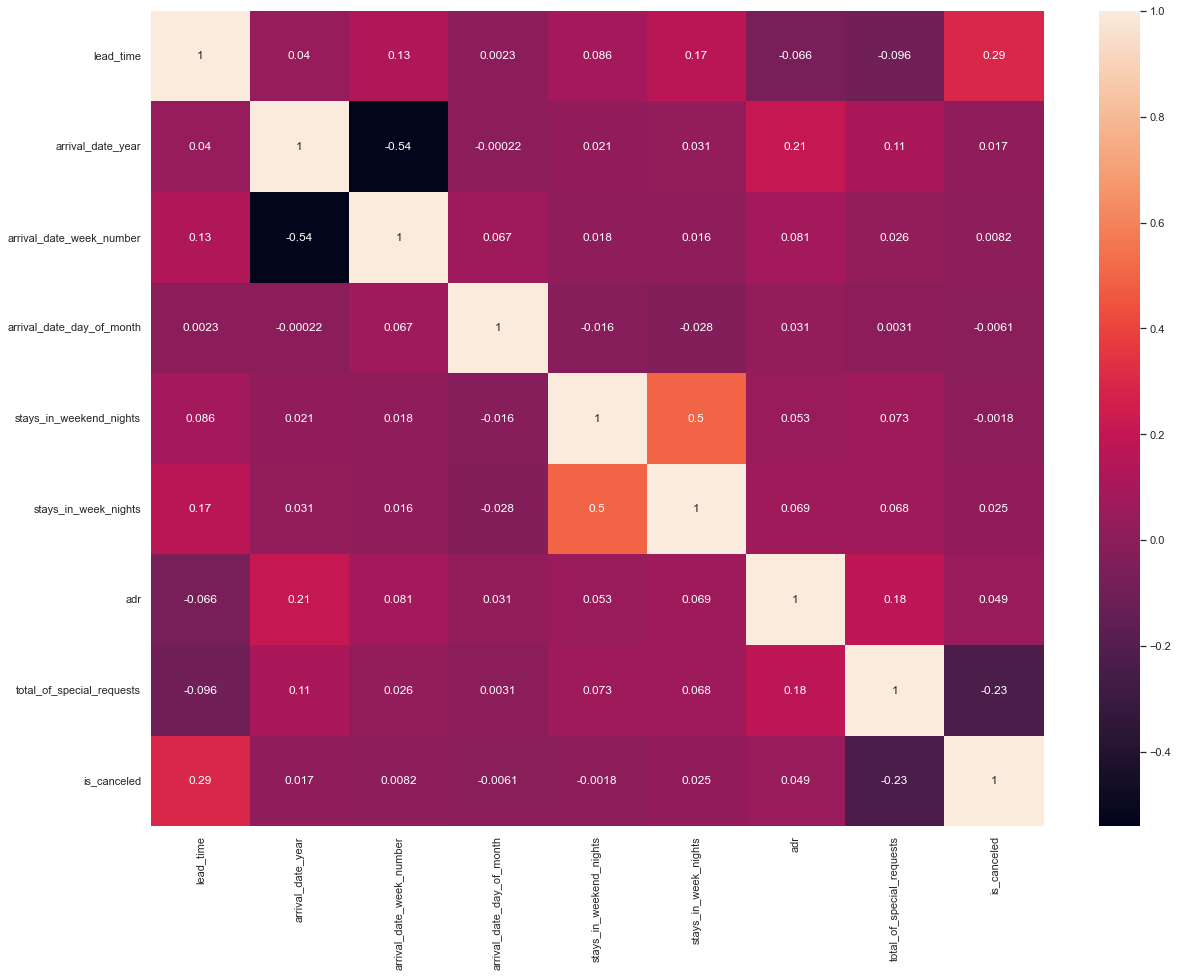

In [245]:
# Caculate correlation coefficients.
dfnumeric = df.select_dtypes(include='number')
dfheatmap = dfnumeric.copy()
dfheatmap['is_canceled'] = df['is_canceled'].astype('float') 
plt.figure(figsize=(20, 15))
sns.heatmap(dfheatmap.corr(),annot=True)
plt.show('png')

### 3.3 Categorical Variables

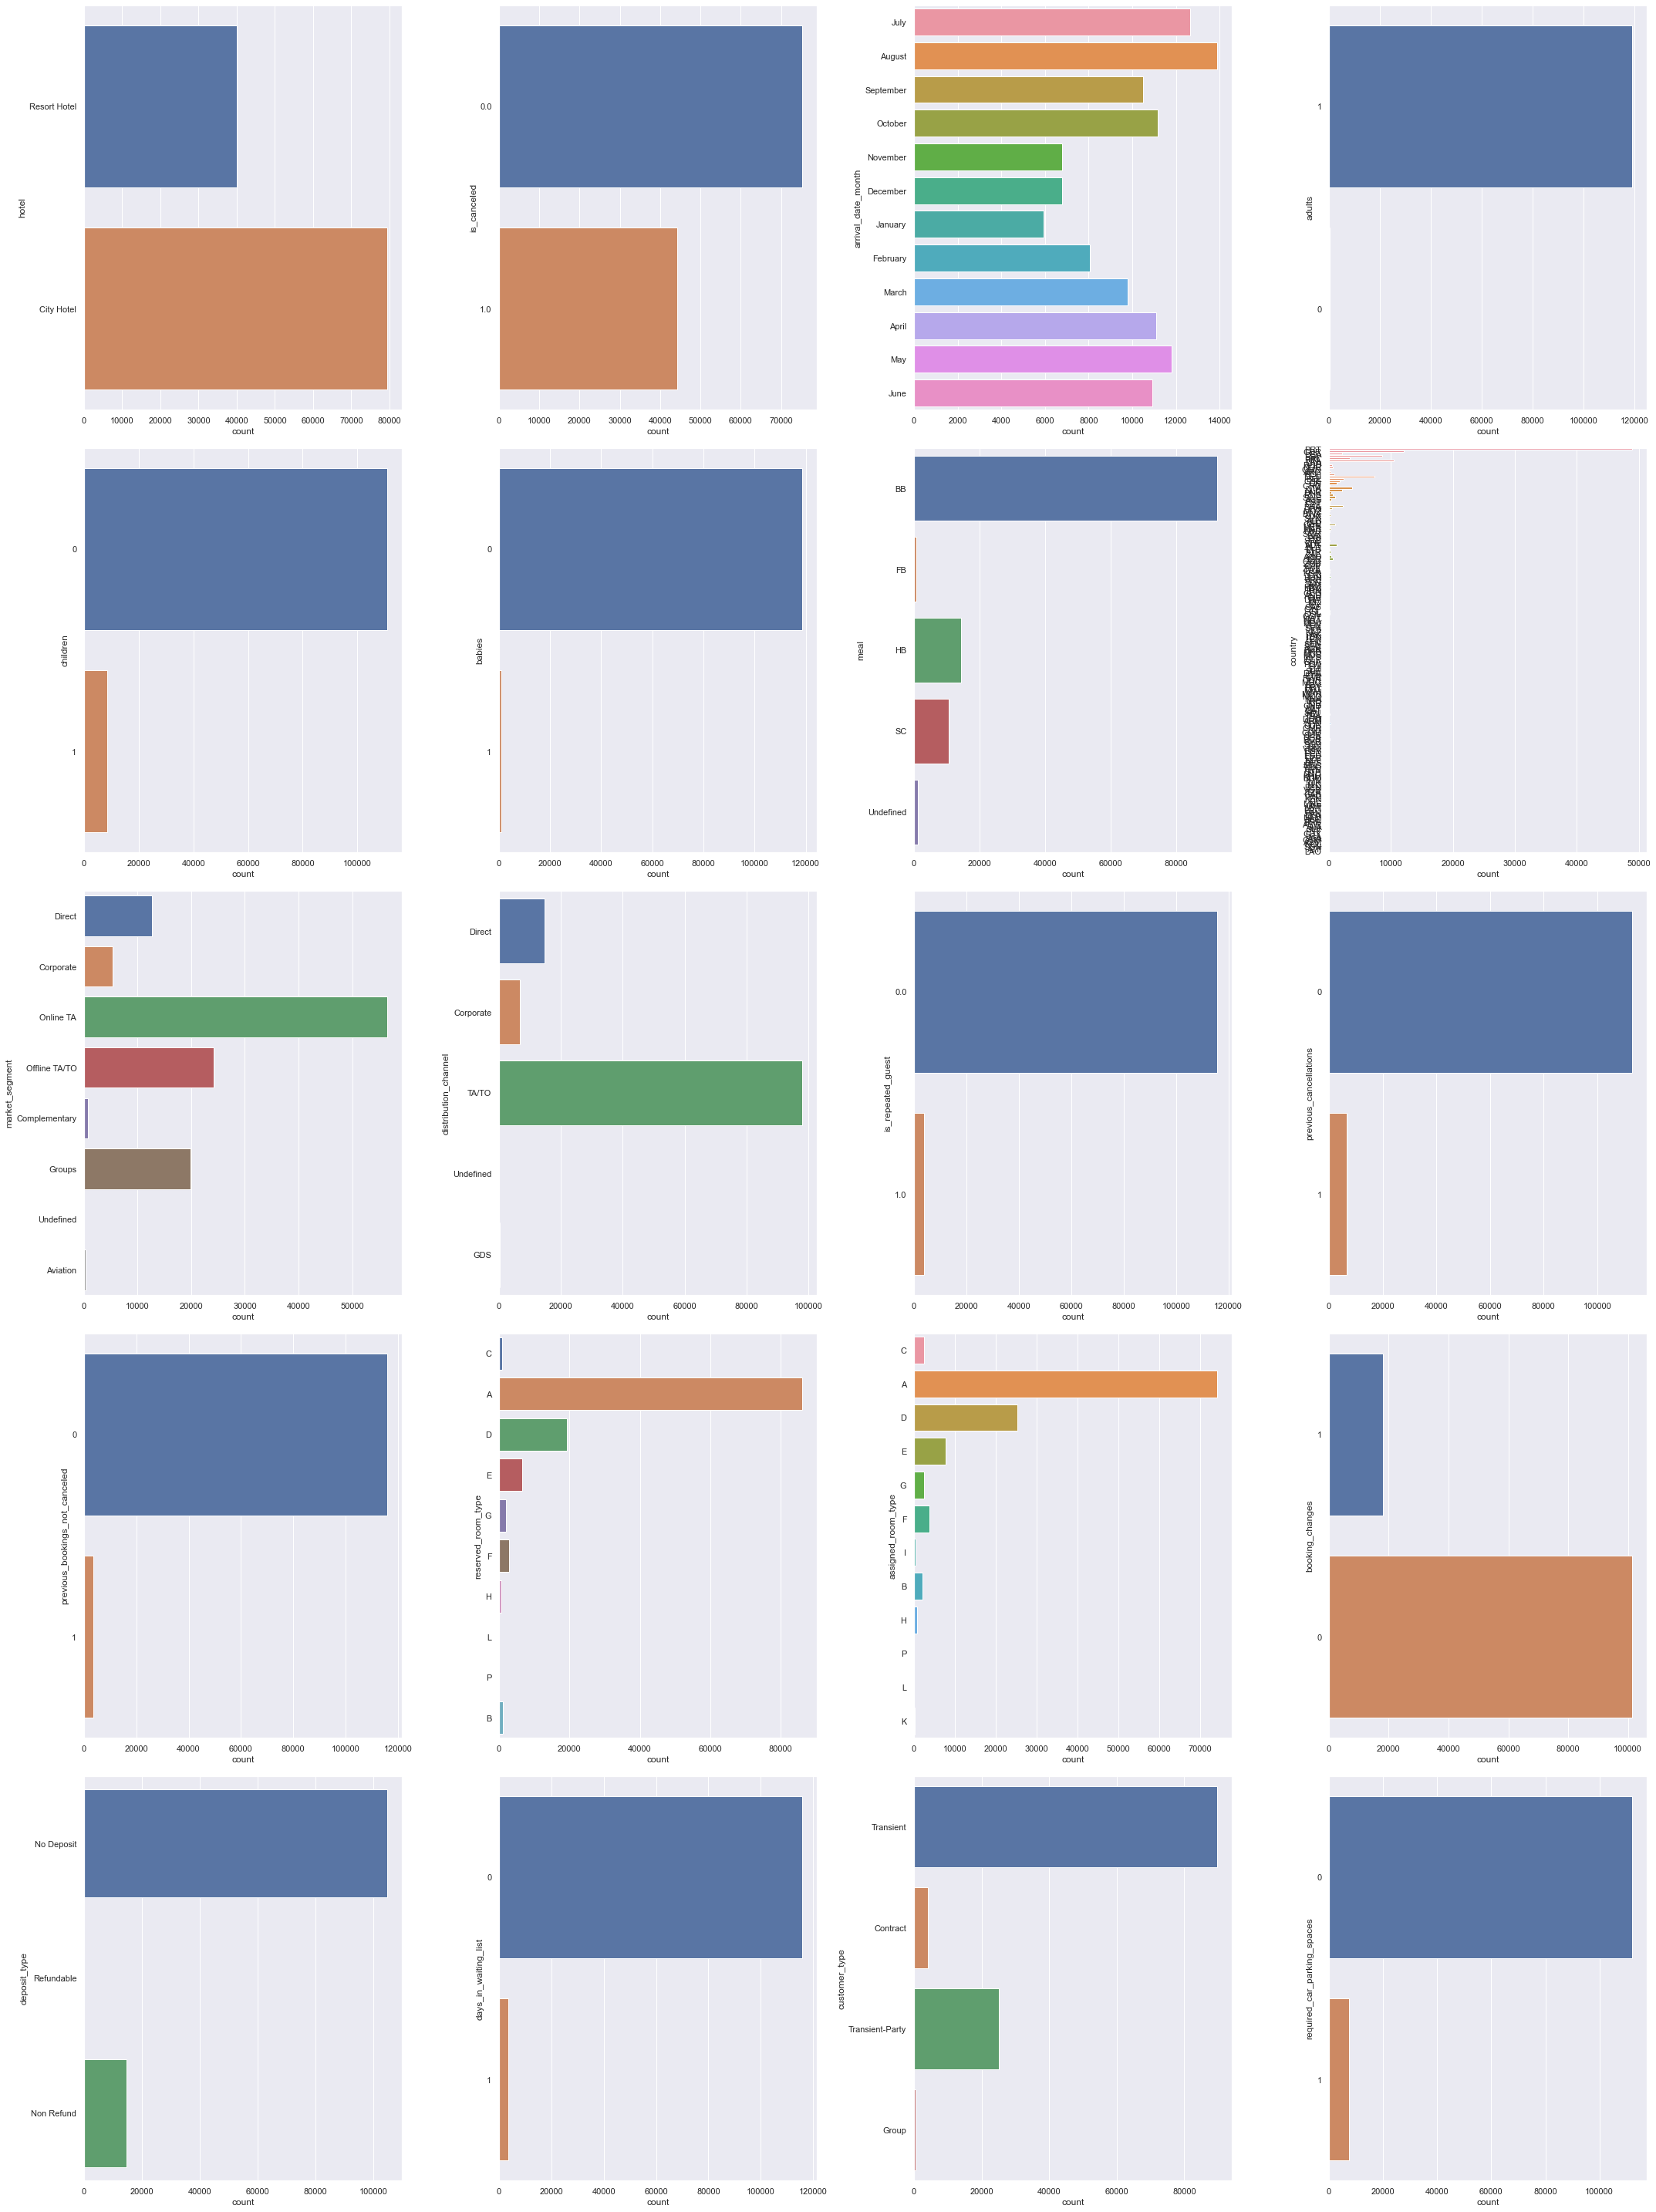

In [246]:
dfcatforplot = df.select_dtypes(include='object').drop(['reservation_status_date','agent'],axis=1)
names = dfcatforplot.columns
ncols = len(names)
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(30,40))

for name, ax in zip(names, axes.flatten()):
    sns.countplot(y=name, data=dfcatforplot, ax=ax)
    
plt.tight_layout()

As those bar plots above in cell 17 shown, some categorical variables have too many catergories with low frequency, so I tried to make it more concise, meanwhile, not to lose too much important information.

   * I reduced variable meal from five categories to three. Outcome equal to SC or Undefined in variable meal means the customers did not reserve the meal, so I made it to the same category, and outcome equal to FB or HB means the customers at least reserved for two meals, so I made it the same category. The last outcome BB means the customer reserved for only one meal.
    
   * Also, I created a new column called Room_Diff to represent if the reserved_room_type is different from assigned_room_type. In this way, I can reduce the categories in these two variables.

In [247]:
#Combine meal categories
def TransMeal(meal):
    if (meal == 'SC')|(meal=='Undefined'):
        return "Meal=0"
    elif (meal == 'FB')|(meal=='HB'):
        return "Meal>=2"
    else:
        return "BB"
df['meal'] = df['meal'].apply(lambda x: TransMeal(x))  

#Create a column if reserve room type != assign room type
df['Room_Diff'] = np.where((df.reserved_room_type != df.assigned_room_type),'1','0')

#### 3.3.1 Country

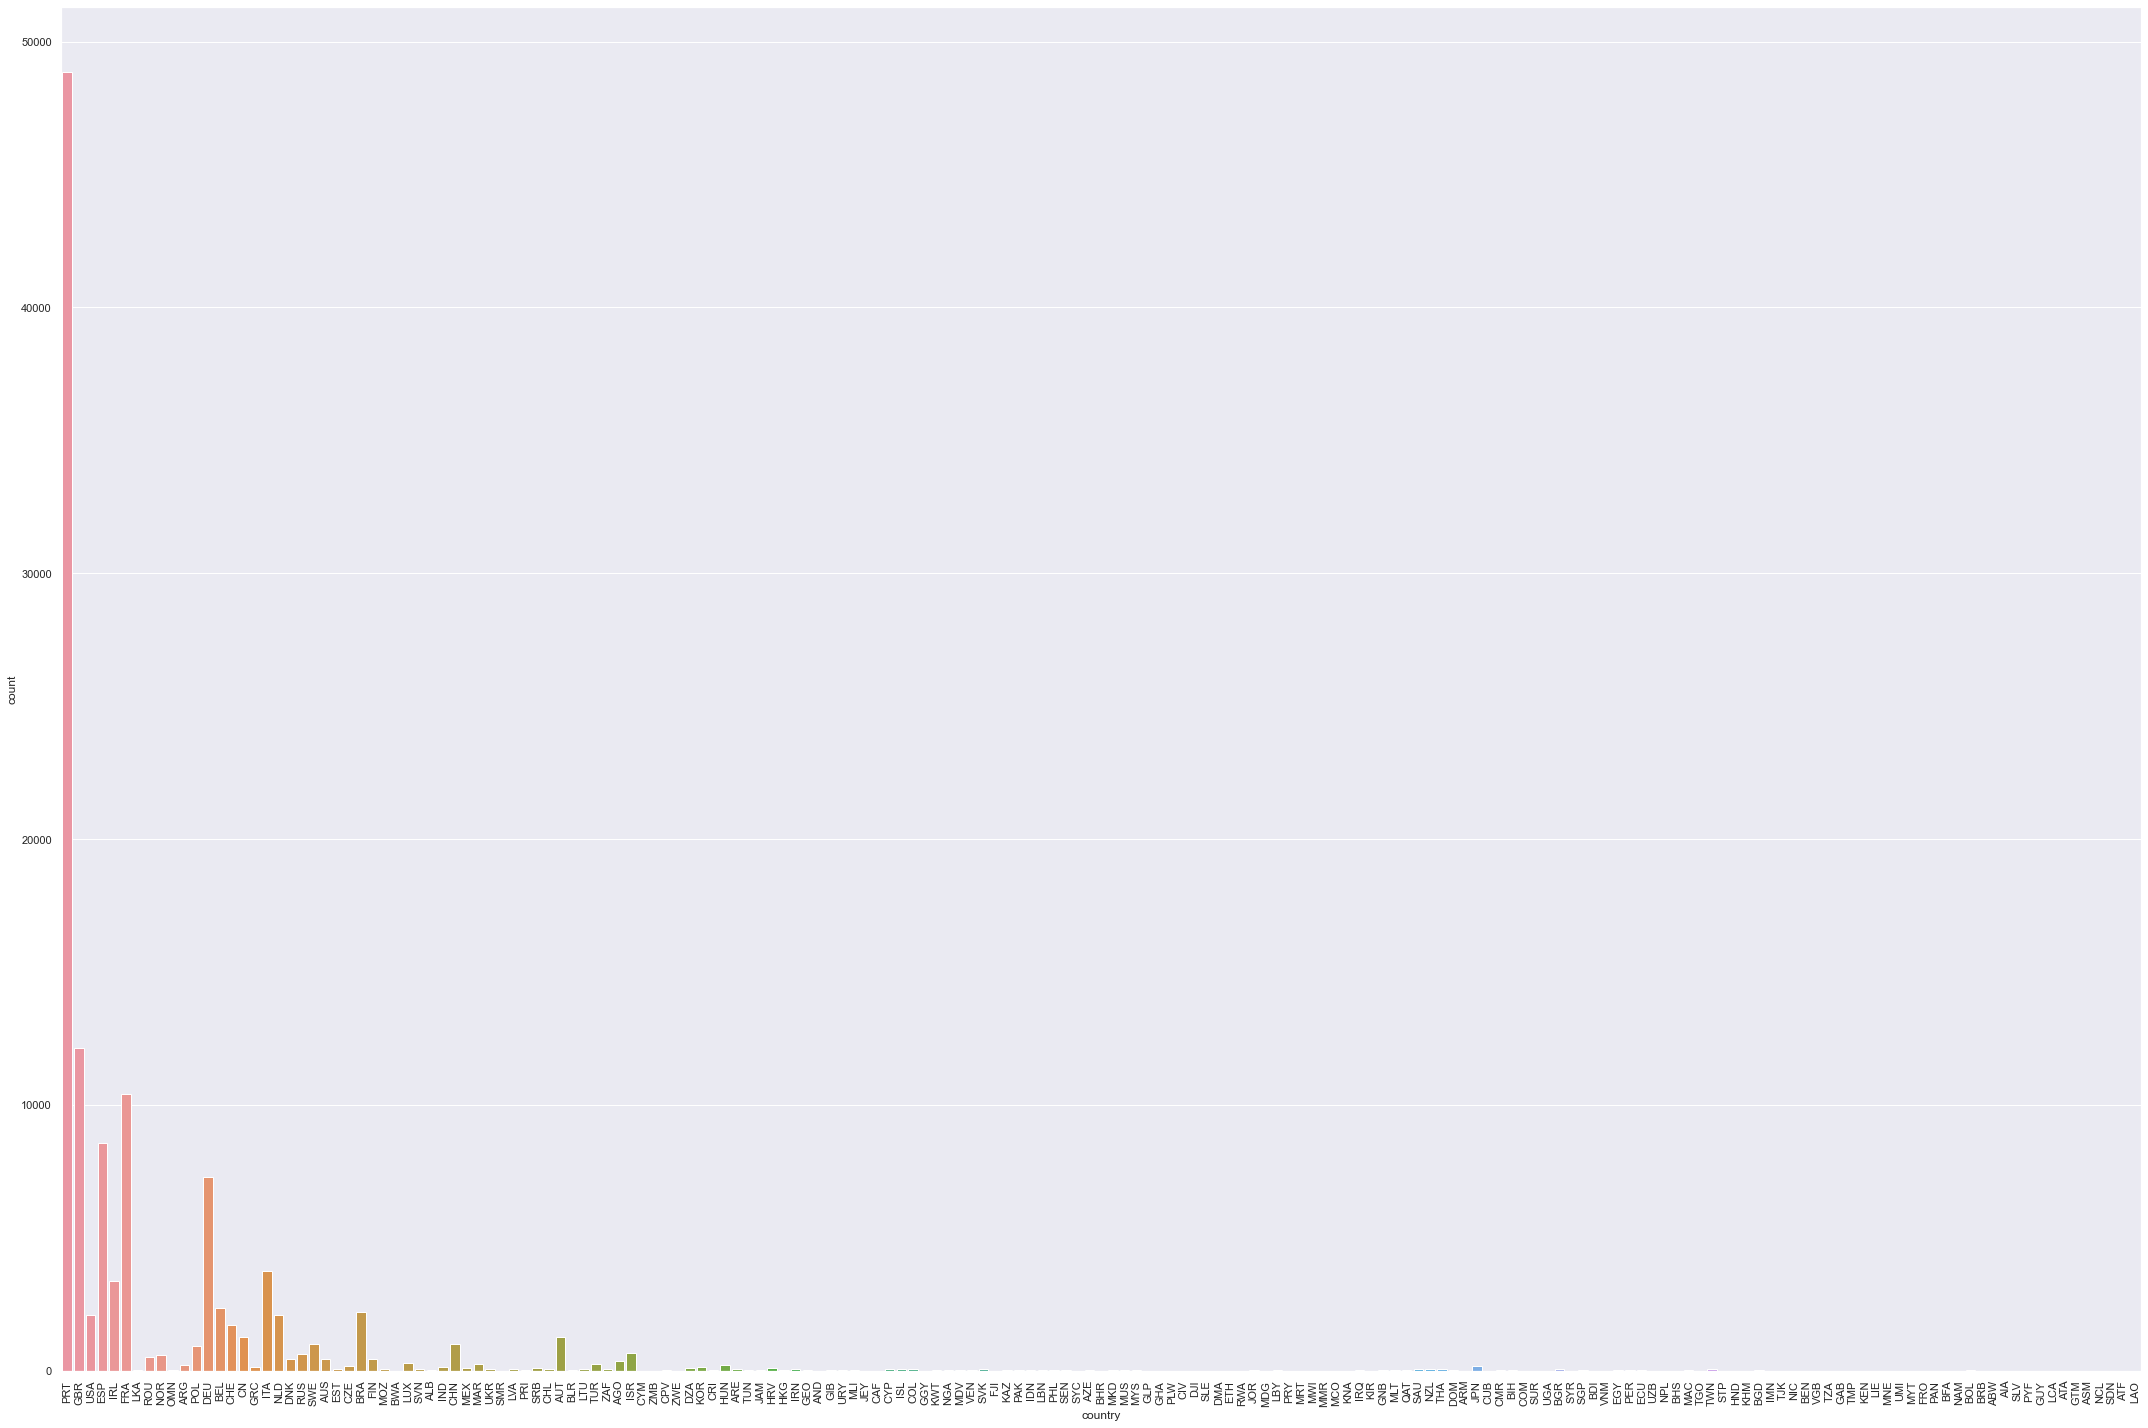

In [248]:
plt.figure(figsize=(30,20))
sns.countplot(x='country', data=df)
plt.xticks(rotation=90)
plt.tight_layout()

As the bar plot in cell 19 shown, there are too many countries with low frequency in our data, so we decide to break all countries into five continents so that the categories can be reduced.

The plot in cell 20 tells us most data in our dataframe are from Europe, and there are a few countries from Antarctica.

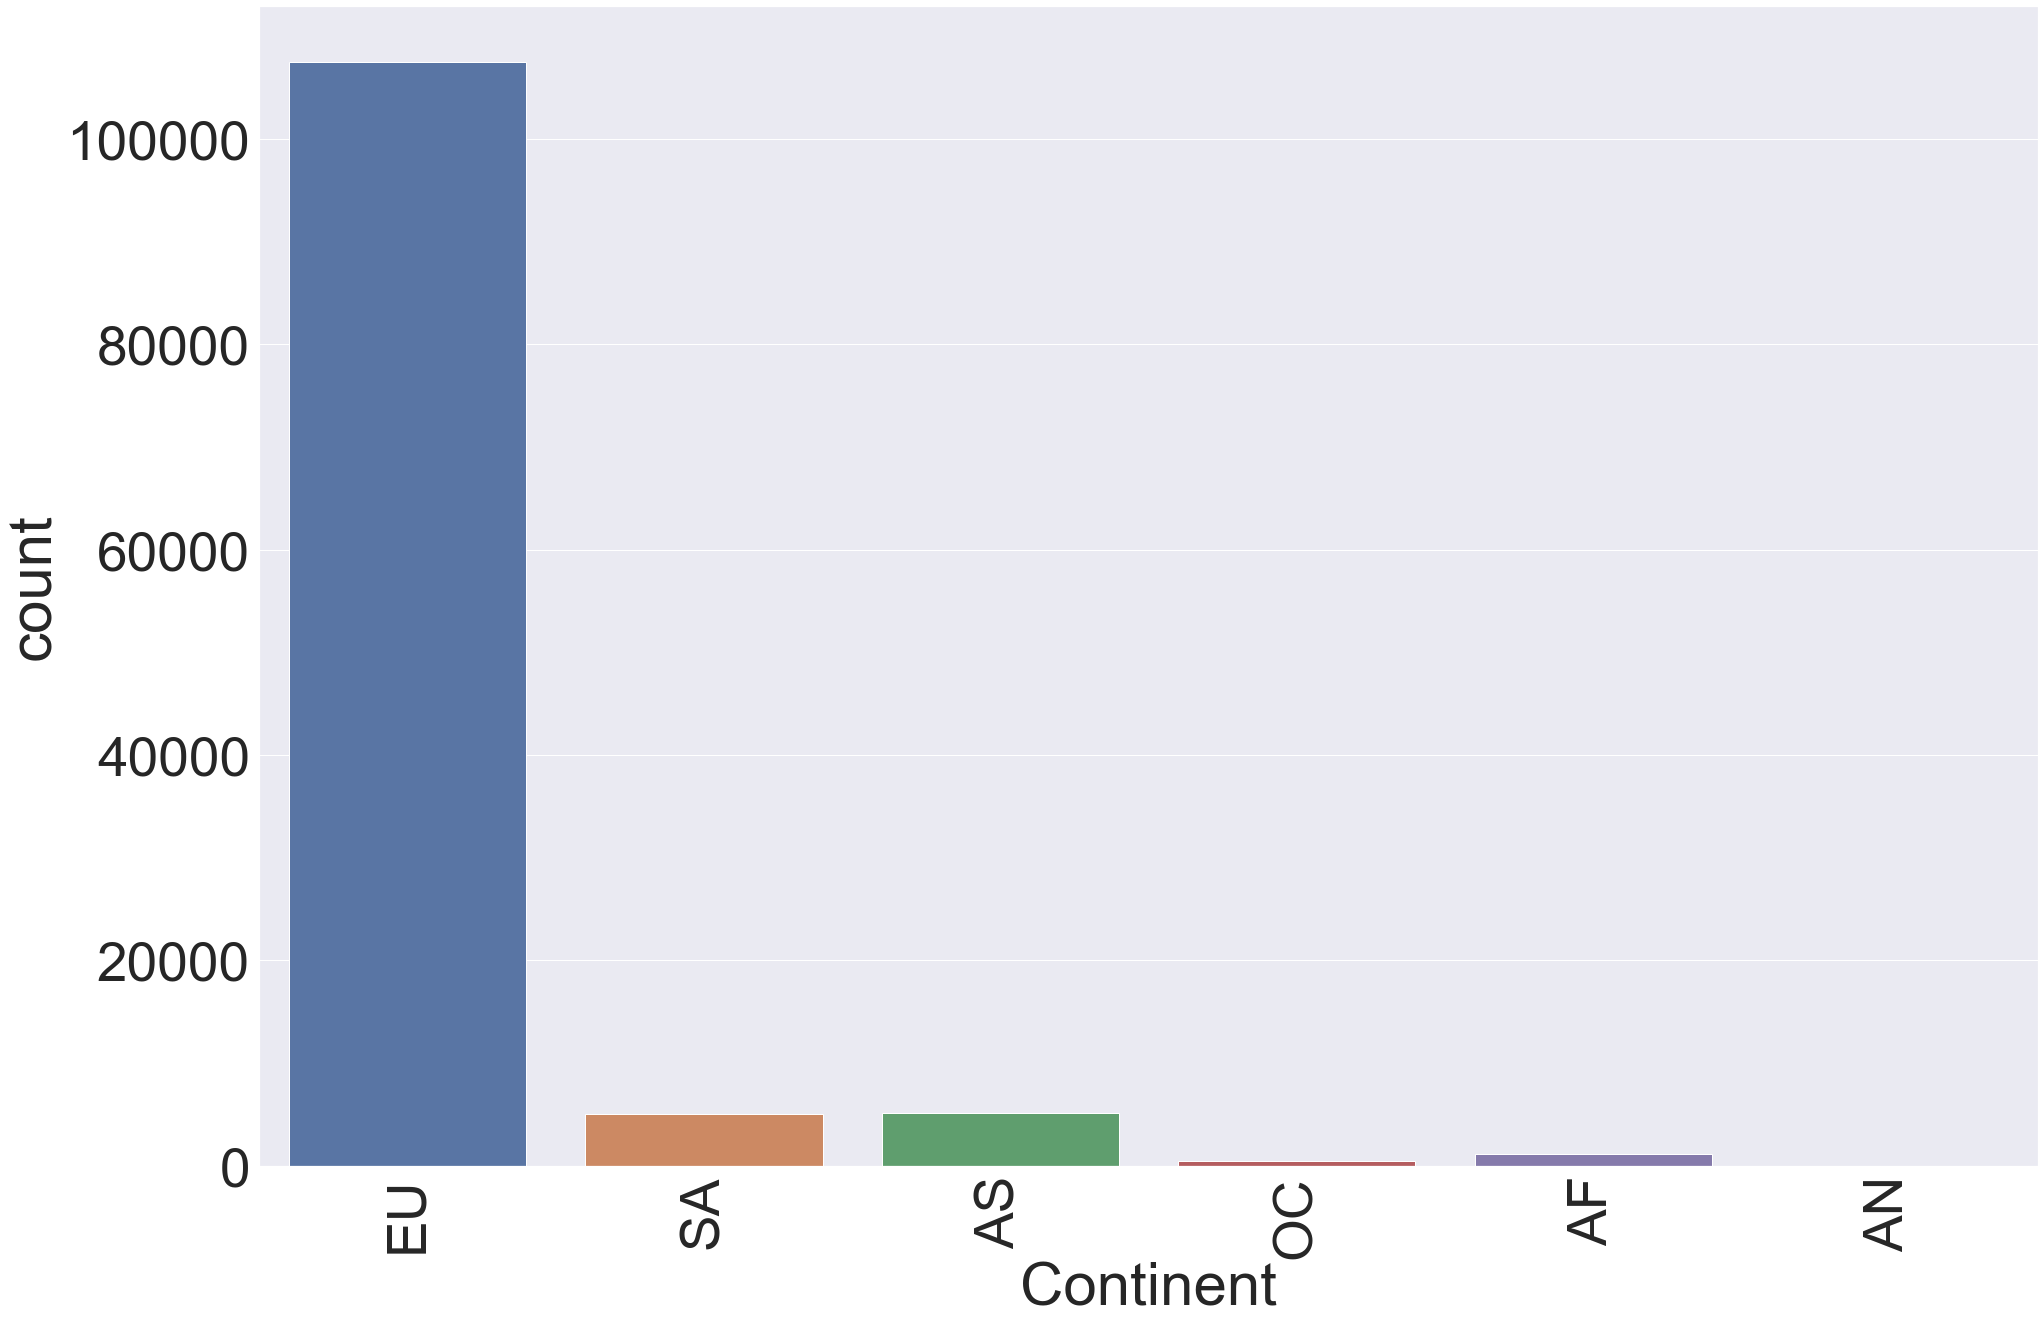

In [249]:
df['country'] = df['country'] .replace(['CN'],'CHN')
df['country'] = df['country'] .replace(['TMP'],'CHN')
df['country'] = df['country'] .replace(['UMI'],'USA')
country = []
for x in df['country']:
    country.append(pc.countries.get(alpha_3='%s'%x).alpha_2)
df['countryupdated'] = country

dfc= pd.read_csv('countries_codes_and_coordinates.csv',encoding = "ISO-8859-1")
AF = list(dfc[dfc['Cont']=='AF']['Alpha2'])
AN = list(dfc[dfc['Cont']=='AN']['Alpha2'])
AS = list(dfc[dfc['Cont']=='AS']['Alpha2'])
EU = list(dfc[dfc['Cont']=='EU']['Alpha2'])
NA = list(dfc[dfc['Cont']=='NA']['Alpha2'])
OC = list(dfc[dfc['Cont']=='OC']['Alpha2'])
SA = list(dfc[dfc['Cont']=='SA']['Alpha2'])
def GetConti(counry):
    if counry in AF:
        return "AF"
    elif counry in AN:
        return "AN"
    elif counry in AS:
        return "AS"
    elif counry in EU:
        return "EU"
    elif counry in NA:
        return "NA"
    elif counry in OC:
        return "OC"
    else:
        return "SA"

df['Continent'] = df['countryupdated'].apply(lambda x: GetConti(x))

df['Continent'] 

plt.figure(figsize=(30,20))
sns.set(font_scale=5)
sns.countplot(x='Continent', data=df)
plt.xticks(rotation=90)
plt.tight_layout()



#### 3.3.2 Relationship between the categorical independent variables and the dependent variable

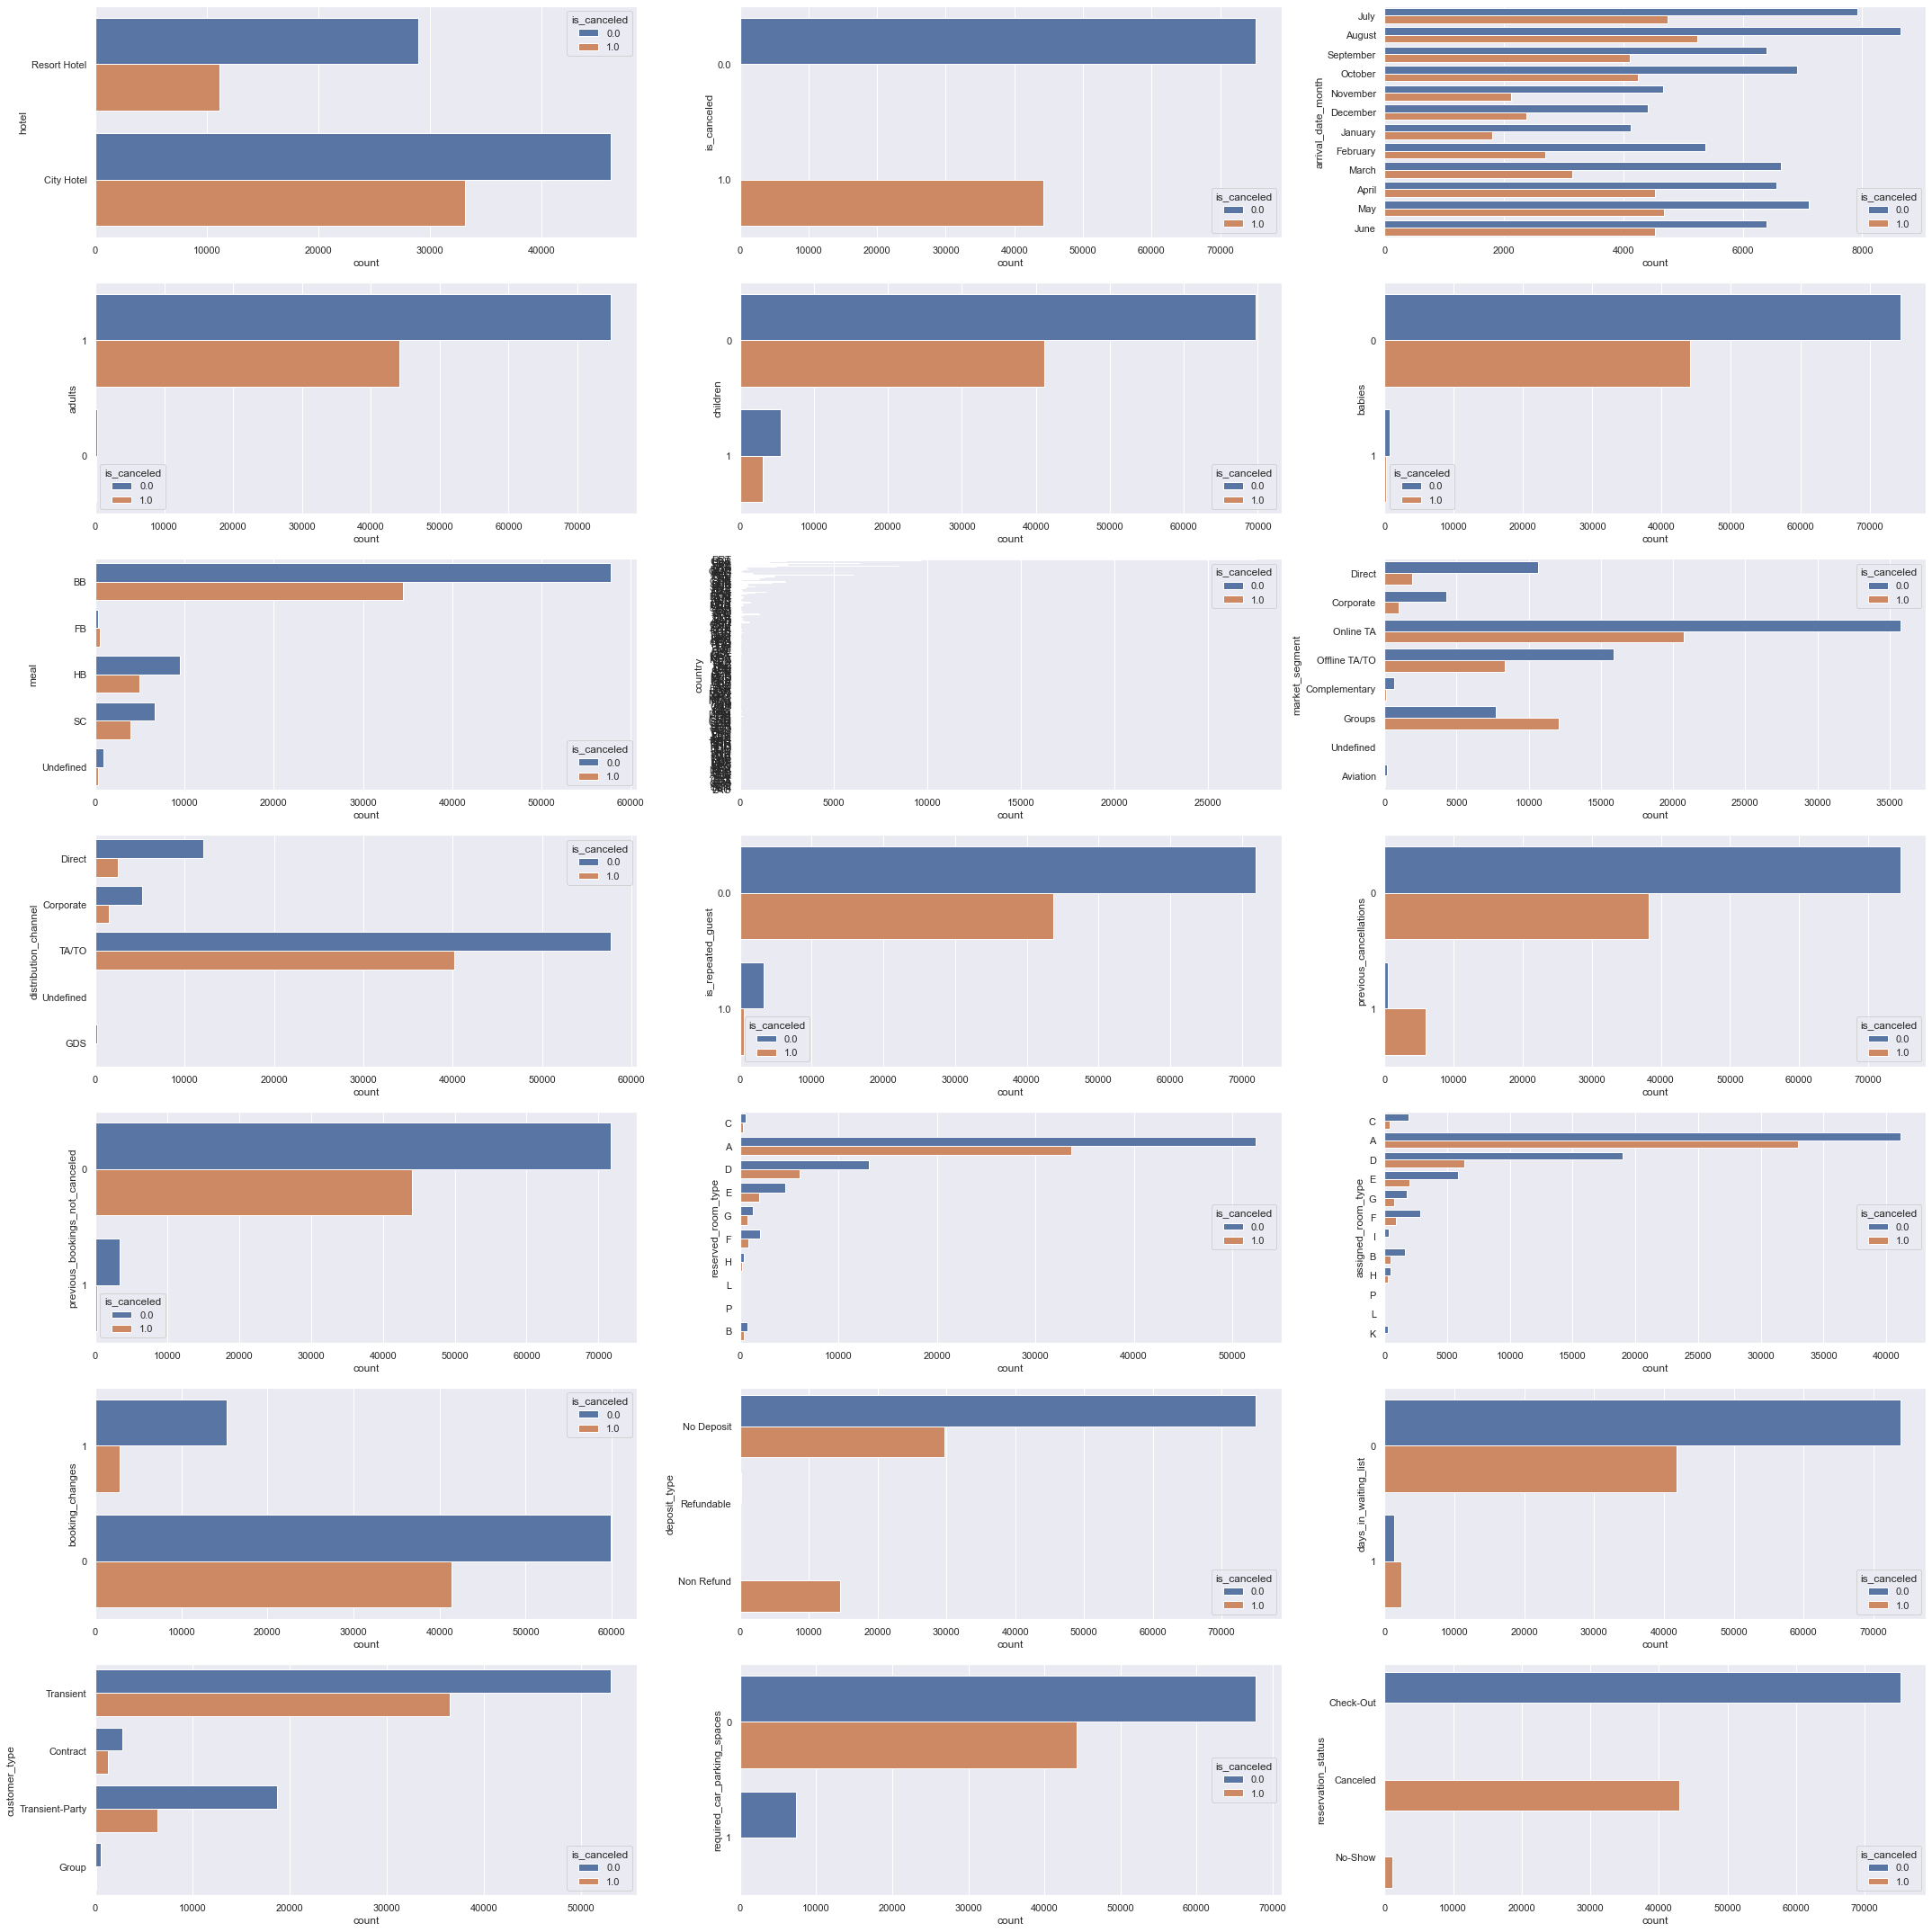

In [250]:
names = dfcatforplot.columns
ncols = len(names)
sns.set(font_scale=1)   
fig, axes = plt.subplots(nrows=7, ncols=3,figsize=(30,30))

for name, ax in zip(names, axes.flatten()):
    sns.countplot(y=name, data=dfcatforplot, ax=ax,hue='is_canceled')    
plt.tight_layout()

As the plot shown in cell 21, reservation_status seems to be have high correlation with the target variable. After checking the meaning of this variable, we should remove this variable from our predictors because in reality if we know this status, there is nothing we need to predict.

### 3.3 Time Series Data

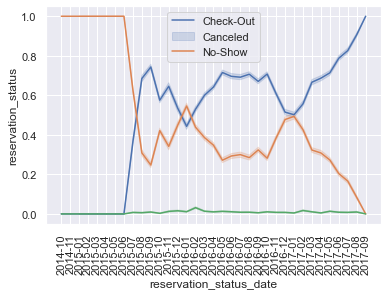

In [251]:
#dfnumeric.columns
#'reservation_status', 'reservation_status_date'
#'lead_time', 'arrival_date_year', 'arrival_date_week_number',
    #'arrival_date_day_of_month', 'stays_in_weekend_nights','stays_in_week_nights','days_in_waiting_list'


dftimeplot = df.sort_values(by='reservation_status_date')   
        
sns.lineplot(x = "reservation_status_date", y = dftimeplot["reservation_status"]=="Check-Out", data = dftimeplot)
sns.lineplot(x = "reservation_status_date", y = dftimeplot["reservation_status"]=="Canceled", data = dftimeplot)
sns.lineplot(x = "reservation_status_date", y = dftimeplot["reservation_status"]=="No-Show", data = dftimeplot)
plt.xticks(rotation=90)
plt.legend(labels=['Check-Out','Canceled','No-Show'])

Trying to find out if there is a pattern in our time series data, from cell 22, we can conclude that during the winter the reserveration is more likely to be canceled.

### 3.4 ANOVA 

We selected the numerical predictors based on their correlation with our dependent variable, and in terms of categorical predictors, we conduct ANOVA test to choose the categorical predictors based on the 95% confidence level.

In [252]:
# Create dummy variables
df=df.drop(['reserved_room_type','reservation_status','reservation_status_date' ,'assigned_room_type','countryupdated','country'],axis=1)

dfdummy = df.select_dtypes(include='object')


In [253]:
dfdummy = pd.get_dummies(dfdummy, drop_first=True)

#df.rename(columns={'is_canceled_1': 'is_canceled', 'adults_1': 'adults','children_1': 'children','babies_1': 'babies','is_repeated_guest_1': 'is_repeated_guest','previous_cancellations_1':'previous_cancellations','previous_bookings_not_canceled_1': 'previous_bookings_not_canceled', 'booking_changes_1': 'booking_changes','days_in_waiting_list_1': 'days_in_waiting_list','required_car_parking_spaces_1':'required_car_parking_spaces','Room_Diff_1':'Room_Diff'}, inplace=True)
#df.columns = df.columns.str.replace('/', '_')
#df.columns = df.columns.str.replace('-', '_')
#df.columns = df.columns.str.replace('>=', 'Bigger')
#df.columns = df.columns.str.replace('=', 'Equal')
X=dfdummy[dfdummy.columns.difference(['is_canceled_1.0'])]
Y=dfdummy['is_canceled_1.0']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

const                               0.268512
Continent_AN                       -0.437514
Continent_AS                       -0.107044
Continent_EU                       -0.115075
Continent_OC                       -0.208783
                                      ...   
meal_Meal=0                         0.008816
meal_Meal>=2                        0.020250
previous_bookings_not_canceled_1   -0.162622
previous_cancellations_1            0.329136
required_car_parking_spaces_1      -0.282158
Length: 484, dtype: float64

In [254]:
A=[results.pvalues.round(4)]
pvale = pd.DataFrame(A)
pvale = pvale.T[pvale.T[0]<=0.05]
pvale.index

Index(['const', 'Continent_AS', 'Continent_EU', 'Continent_OC', 'Continent_SA',
       'Room_Diff_1', 'agent_104.0', 'agent_11.0', 'agent_110.0',
       'agent_111.0',
       ...
       'deposit_type_Refundable', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'distribution_channel_Undefined',
       'market_segment_Groups', 'meal_Meal=0', 'meal_Meal>=2',
       'previous_bookings_not_canceled_1', 'previous_cancellations_1',
       'required_car_parking_spaces_1'],
      dtype='object', length=161)

# 4. Data Processing

## 4.1 Split Data

We split the data to test set and trainning set based on the proportion of the value in target variable. After splitting we can observe from cell 27, training is unbalanced, so we apply SMOTH method to rebuild this data, making it balanced. This can be found in cell 28.

In [264]:
predictors = [x for x in pvale.index]
predictors.remove('const')
dfdummy[predictors] = dfdummy[predictors].astype('object')
dfnew = pd.concat([df,dfdummy[predictors]],axis=1)
predictors.append('lead_time')
predictors.append('total_of_special_requests')
X = dfnew[predictors]
y = dfnew['is_canceled'].astype(int).round()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify=y)


Text(0.5, 1.0, 'ytest')

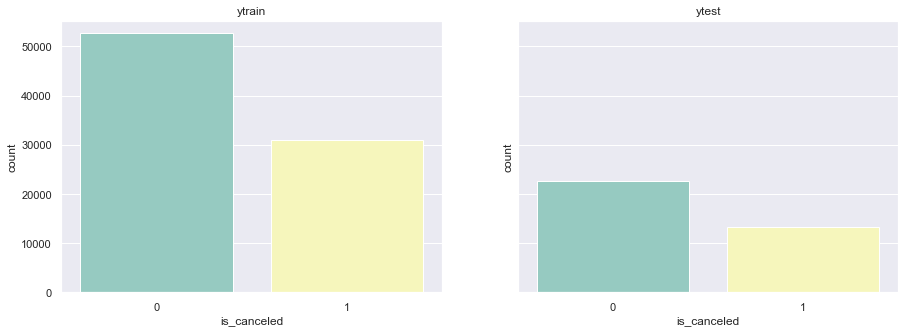

In [267]:
ytrain = pd.DataFrame(data=y_train,columns=['is_canceled'])
ytest = pd.DataFrame(data=y_test,columns=['is_canceled'])


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(ax=axes[0], x="is_canceled", data=ytrain, palette="Set3").set_title('ytrain')
sns.countplot(ax=axes[1], x="is_canceled", data=ytest, palette="Set3").set_title('ytest')


Text(0.5, 1.0, 'ytrain')

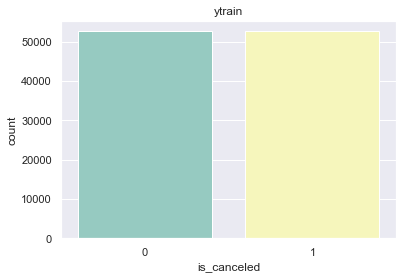

In [268]:
sm = SMOTE(random_state=21)
X_train, y_train = sm.fit_resample(X_train, y_train)
ytrain = pd.DataFrame(data=y_train,columns=['is_canceled'])
sns.countplot(x="is_canceled", data=ytrain, palette="Set3").set_title('ytrain')

## 4.2 Normalize Data

In [269]:
# Normalize Data

X_train_numeric = X_train[[x for x in X_train.select_dtypes(include='number').columns]]
X_train_numeric = (X_train_numeric - X_train_numeric.mean())/X_train_numeric.std()
X_train = pd.merge(X_train[[x for x in X_train.select_dtypes(include='object').columns]], X_train_numeric, left_index=True, right_index=True)
X_train = X_train.astype('float64')

X_test_numeric = X_test[[x for x in X_test.select_dtypes(include='number').columns]]
X_test_numeric = (X_test_numeric - X_train_numeric.mean())/X_train_numeric.std()
X_test = pd.merge(X_test[[x for x in X_test.select_dtypes(include='object').columns]], X_test_numeric, left_index=True, right_index=True)
X_test = X_test.astype('float64')

# 5. Model Training

We choose AUC as our metric because it can tell us how good is our model in general and in different threshold, and we also compare the time used by each model as well to evaluate the time efficiency in each model.

## 5.1 Logistic benhmark

After applying 5 cross validation, we know that when C =1, and penalty = l2, the model perfrom the best in reank_test AUC. 

* AUC is 0.88 when applying to the test set.
* It costs 2 min to run this model.

In [270]:
start_time = time.time()
grid = {"C":np.logspace(-3,3,7), "penalty":["none","l2"]}

scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision','f1':'f1'}
LogGrid = GridSearchCV(estimator=LogisticRegression(),param_grid=grid,cv=5,scoring=scoring, refit='AUC')
LogGrid_results = LogGrid.fit(X_train, y_train).cv_results_
LogGridresults=pd.DataFrame(LogGrid_results)
#LogGridresults=LogGridresults[['mean_test_precision','mean_test_accuracy','mean_test_f1','mean_test_recall']]
print("--- %s seconds ---" % (time.time() - start_time))
LogGridresults[['param_C', 'param_penalty', 'params','mean_test_Accuracy','mean_test_AUC','mean_test_f1','rank_test_AUC']]

--- 129.56988906860352 seconds ---


,param_C,param_penalty,params,mean_test_Accuracy,mean_test_AUC,mean_test_f1,rank_test_AUC
0,0.001,none,"{'C': 0.001, 'penalty': 'none'}",0.798426,0.890888,0.796150,2
1,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.777055,0.861911,0.765217,14
2,0.01,none,"{'C': 0.01, 'penalty': 'none'}",0.798426,0.890888,0.796150,2
3,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.790302,0.881963,0.784074,13
4,0.1,none,"{'C': 0.1, 'penalty': 'none'}",0.798426,0.890888,0.796150,2
5,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.797172,0.888908,0.793448,12
6,1.0,none,"{'C': 1.0, 'penalty': 'none'}",0.798426,0.890888,0.796150,2
7,1.0,l2,"{'C': 1.0, 'penalty': 'l2'}",0.798655,0.890751,0.796224,11
8,10.0,none,"{'C': 10.0, 'penalty': 'none'}",0.798426,0.890888,0.796150,2
9,10.0,l2,"{'C': 10.0, 'penalty': 'l2'}",0.798607,0.890890,0.796407,1


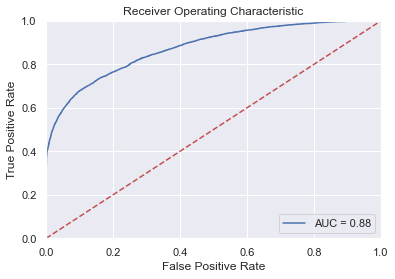

In [271]:
model = LogisticRegression(penalty='l2',C=100)
logmodel = model.fit(X_test, y_test)
# calculate the fpr and tpr for all thresholds of the classification
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_logmodel = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_logmodel)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5.2 kNN

In KNN, finding the value of k is not easy. A small value of k means that noise will have a higher influence on the result and a large value make it computationally expensive.

Data scientists usually choose :

- An odd number if the number of classes is 2

- Another simple approach to select k is set k = sqrt(n). where n = number of data points in training data.

so we decide to train our k from 1 to 161, and as n=41, our model perform the best.

* AUC is 0.85 in test set.
* It costs 34 min to run this model.

In [272]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision','f1':'f1'}
grid = {'n_neighbors': np.arange(1, 162, 40)}
kNNGrid = GridSearchCV(estimator=KNeighborsClassifier(),param_grid=grid,cv=5,scoring=scoring, refit='AUC')
kNNGrid_results = kNNGrid.fit(X_train, y_train).cv_results_
kNNGridresults=pd.DataFrame(kNNGrid_results)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2018.2995760440826 seconds ---


In [273]:
kNNGridresults[['param_n_neighbors','params','mean_test_Accuracy','mean_test_AUC','mean_test_f1','rank_test_AUC']]

,param_n_neighbors,params,mean_test_Accuracy,mean_test_AUC,mean_test_f1,rank_test_AUC
0,1,{'n_neighbors': 1},0.841085,0.841085,0.836878,5
1,41,{'n_neighbors': 41},0.813488,0.902753,0.809078,1
2,81,{'n_neighbors': 81},0.802152,0.892143,0.798762,2
3,121,{'n_neighbors': 121},0.795889,0.888001,0.793523,3
4,161,{'n_neighbors': 161},0.791594,0.885241,0.789974,4


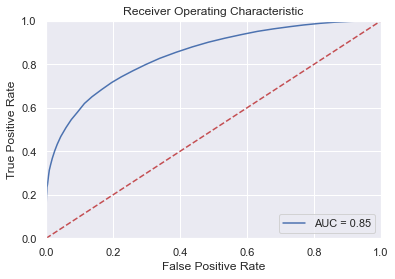

In [274]:
model = KNeighborsClassifier(n_neighbors=41)
knnmodel = model.fit(X_test, y_test)
# calculate the fpr and tpr for all thresholds of the classification
probs = knnmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_knnmodel = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_knnmodel)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5.3 Decision Tree

In order to prevent overfitting, we set max depth in our model, and use 5 cross validiation to train our model. As the max depth is 16, our model perfrom the best.

* AUC in test set is 0.93.

* It costs 3.5 min to run this model.

In [275]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision','f1':'f1'}
grid = {'max_depth': np.arange(1, 100, 3)}
DTGrid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1021),cv=5,scoring=scoring, refit='AUC',param_grid=grid)
DTGrid_results = DTGrid.fit(X_train, y_train).cv_results_
DTGridresults=pd.DataFrame(DTGrid_results)
print("--- %s seconds ---" % (time.time() - start_time))

--- 199.05273604393005 seconds ---


In [276]:
DTGridresults[['param_max_depth','params','mean_test_Accuracy','mean_test_AUC','mean_test_f1','rank_test_AUC']]

,param_max_depth,params,mean_test_Accuracy,mean_test_AUC,mean_test_f1,rank_test_AUC
0,1,{'max_depth': 1},0.663591,0.663591,0.493974,33
1,4,{'max_depth': 4},0.729160,0.808655,0.731393,32
2,7,{'max_depth': 7},0.797780,0.874072,0.769010,31
3,10,{'max_depth': 10},0.806713,0.901360,0.797849,6
4,13,{'max_depth': 13},0.823638,0.913021,0.819133,3
5,16,{'max_depth': 16},0.830803,0.916797,0.821854,1
6,19,{'max_depth': 19},0.836571,0.916081,0.828110,2
7,22,{'max_depth': 22},0.840154,0.911117,0.830609,4
8,25,{'max_depth': 25},0.842577,0.903742,0.833146,5
9,28,{'max_depth': 28},0.844592,0.896676,0.836491,7


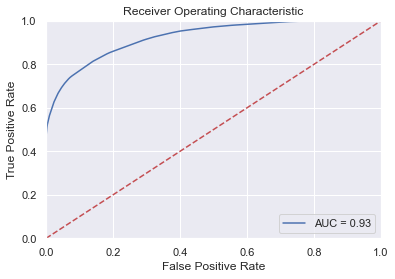

In [277]:
model = DecisionTreeClassifier(random_state=1021,max_depth=16)
DTmodel = model.fit(X_test, y_test)
# calculate the fpr and tpr for all thresholds of the classification
probs = DTmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_DTmodel = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_DTmodel)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

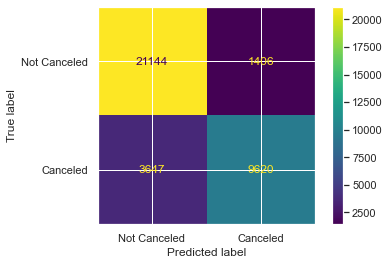

In [278]:
plot_confusion_matrix(DTmodel,
                      X_test,
                      y_test,
                      display_labels=['Not Canceled','Canceled']
                     )

## 5.4 Random Forest

In the random forest case, we set max depth as well, as value is equal to 40, the AUC is 0.95.

* AUC in test set is 0.98.
* It costs 37 min to run this model. 

In [279]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision','f1':'f1'}
grid = {'max_depth': np.arange(1, 100, 3)}
RFGrid = GridSearchCV(estimator=RandomForestClassifier(random_state=1021),cv=5,scoring=scoring, refit='AUC',param_grid=grid)
RFGrid_results = RFGrid.fit(X_train, y_train).cv_results_
RFGridresults=pd.DataFrame(RFGrid_results)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2238.7073788642883 seconds ---


In [280]:
RFGridresults[['param_max_depth','params','mean_test_Accuracy','mean_test_AUC','mean_test_f1','rank_test_AUC','mean_test_recall','mean_test_precision']]

,param_max_depth,params,mean_test_Accuracy,mean_test_AUC,mean_test_f1,rank_test_AUC,mean_test_recall,mean_test_precision
0,1,{'max_depth': 1},0.764625,0.856311,0.733143,33,0.648149,0.844794
1,4,{'max_depth': 4},0.774584,0.880683,0.753232,32,0.691386,0.830575
2,7,{'max_depth': 7},0.799396,0.894494,0.789561,31,0.758838,0.826297
3,10,{'max_depth': 10},0.808861,0.904706,0.801497,30,0.775525,0.830806
4,13,{'max_depth': 13},0.822516,0.914377,0.812957,29,0.776038,0.855464
5,16,{'max_depth': 16},0.835545,0.922889,0.827667,28,0.796413,0.863885
6,19,{'max_depth': 19},0.844763,0.929226,0.836576,27,0.803369,0.875721
7,22,{'max_depth': 22},0.853163,0.934098,0.846418,26,0.819296,0.878605
8,25,{'max_depth': 25},0.860898,0.938662,0.853850,25,0.826024,0.888063
9,28,{'max_depth': 28},0.865612,0.941558,0.858868,13,0.832410,0.891566


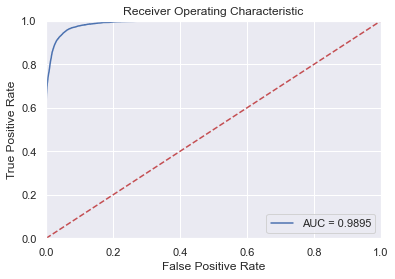

In [281]:
model = RandomForestClassifier(random_state=1021,max_depth=40)
RFmodel = model.fit(X_test, y_test)
# calculate the fpr and tpr for all thresholds of the classification
probs = RFmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_RFmodel = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc_RFmodel)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

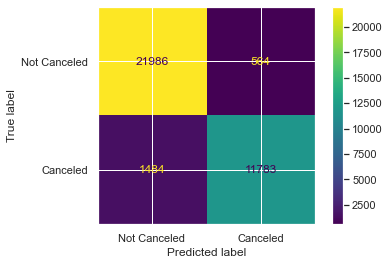

In [282]:
plot_confusion_matrix(RFmodel,
                      X_test,
                      y_test,
                      display_labels=['Not Canceled','Canceled']
                     )

## 5.5 ANN

In the random forest case, we train hidden_layer_sizes through 5 cross validation. As value is equal to (100,0,0), the AUC is 0.94, which is the best among other value.

* AUC in test set is 0.93.
* It costs 58 min to run this model. 

In [283]:
start_time = time.time()
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy','recall':'recall','precision':'precision','f1':'f1'}
grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]}
ANNGrid = GridSearchCV(estimator=MLPClassifier(random_state=1021),cv=5,scoring=scoring, refit='AUC',param_grid=grid)
ANNGrid_results = ANNGrid.fit(X_train, y_train).cv_results_
ANNGridresults=pd.DataFrame(ANNGrid_results)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3481.258085012436 seconds ---


In [287]:
ANNGridresults[['param_hidden_layer_sizes','params','mean_test_Accuracy','mean_test_AUC','mean_test_f1','rank_test_AUC','mean_test_recall','mean_test_precision']]

,param_hidden_layer_sizes,params,mean_test_Accuracy,mean_test_AUC,mean_test_f1,rank_test_AUC,mean_test_recall,mean_test_precision
0,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",0.848526,0.932486,0.845775,3,0.838909,0.855963
1,"(50, 100, 50)","{'hidden_layer_sizes': (50, 100, 50)}",0.850616,0.933280,0.846246,2,0.830775,0.865344
2,"(100,)","{'hidden_layer_sizes': (100,)}",0.850968,0.935539,0.850383,1,0.851320,0.850529


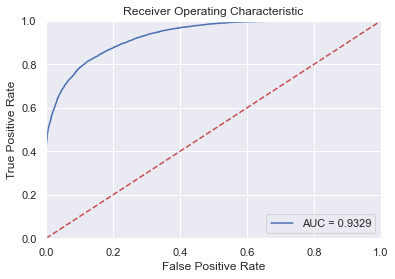

In [286]:
model = MLPClassifier(random_state=1021,hidden_layer_sizes=(100,))
MLPmodel = model.fit(X_test, y_test)
# calculate the fpr and tpr for all thresholds of the classification
probs = MLPmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc_MLPmodel = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc_MLPmodel)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 6. Conclusion

Among all models, the Random Forest model appears to the best model, whose AUC in trainning set can reach to 0.95 and AUC in test set can achieve 0.98. However, it costs 37 minutes to obtain the Random Forest model. If we take into account of the time efficency, the Decision Tree appears to be the best. Its AUC can attain 0.93 in test set, and only use 3.5 minutes.